# Margin Call Likelihood Analysis

In [1]:
import pandas as pd
import numpy as np
from string import digits
import math
from tqdm import tqdm
import yaml
from functools import reduce
from alpha_vantage.timeseries import TimeSeries

import helpers as hlp

from plotly.offline import init_notebook_mode, iplot
import plotly_utilities as pu

# Allow plotly to operate within the notebook
init_notebook_mode()

%load_ext autoreload
%autoreload 2

In [2]:
conf = yaml.load(open('conf.yaml'))
av_key = conf['alpha_vantage_key']

### Define Session Configuration

In [16]:
# Stocks to examine
symbol = "VTS.AX"
symbols = ['ASX:AFI','ASX:ARG','ASX:MLT','ASX:WHF','ASX:XJO','ASX:VTS','ASX:VAS','VTS.AX']

In [4]:
# Loan Vars
starting_lvr = 0.5
max_lvr = 0.65
buffer = 0.1
step_size = 0.01

In [5]:
# Generate Margin Call Drop Lookup Table
df_mc_triggers = hlp.create_margin_call_range_table(max_lvr, buffer, step_size)
df_mc_triggers.head()

lvr  mc_trigger
0  0.00  100.000000
1  0.01   98.666667
2  0.02   97.333333
3  0.03   96.000000
4  0.04   94.666667

## Get Historical Data & Calculate Margin Calls

NOTE: The alpha vantage API is SUPER flakey! You'll likely get a bunch of nonsense errors. Just keep bashing them & eventually they'll submit to your will.

In [ ]:
symbols[]

In [18]:
# mc_results = []
for symbol in symbols[-1]:
    tmp = hlp.margin_call_samples(key = av_key,
                                  symbol = symbol,
                                  time_slice = "weekly",
                                  drawdown_window = 52,
                                  lvr_lookup = df_mc_triggers.copy(deep=True))
    
    mc_results.append(tmp)

KeyError: 'Weekly Time Series'

In [11]:
# Join Historical safe LVR's together
max_safe_lvrs = [(symbols[x], mc_results[x][2] )for x in range(0,len(mc_results))]
max_safe_lvrs = pd.DataFrame(max_safe_lvrs, columns=['Symbol', 'Max Safe LVR'])

max_safe_lvrs.sort_values(by = 'Max Safe LVR')

Symbol  Max Safe LVR
2  ASX:MLT     13.073722
3  ASX:WHF     33.510638
4  ASX:XJO     38.504740
1  ASX:ARG     44.301909
0  ASX:AFI     44.367909
6  ASX:VAS     59.215686
5  ASX:VTS     61.638747

In [12]:
# Join margin call frequencies together
mc_counts = [mc_results[x][1] for x in range(0,len(mc_results))]
df_mc_counts = reduce(lambda x, y: pd.merge(x, y, on = ['lvr','mc_trigger']), mc_counts)

# Conver LVR to a percentage
df_mc_counts['lvr'] = df_mc_counts['lvr'] * 100

df_mc_counts.head()

lvr  mc_trigger  ASX:AFI_mc_count  ASX:ARG_mc_count  ASX:MLT_mc_count  \
0  0.0  100.000000                 0                 0                 0   
1  1.0   98.666667                 0                 0                 0   
2  2.0   97.333333                 0                 0                 0   
3  3.0   96.000000                 0                 0                 0   
4  4.0   94.666667                 0                 0                 0   

   ASX:WHF_mc_count  ASX:XJO_mc_count  ASX:VTS_mc_count  ASX:VAS_mc_count  
0                 0                 0                 0                 0  
1                 0                 0                 0                 0  
2                 0                 0                 0                 0  
3                 0                 0                 0                 0  
4                 0                 0                 0                 0

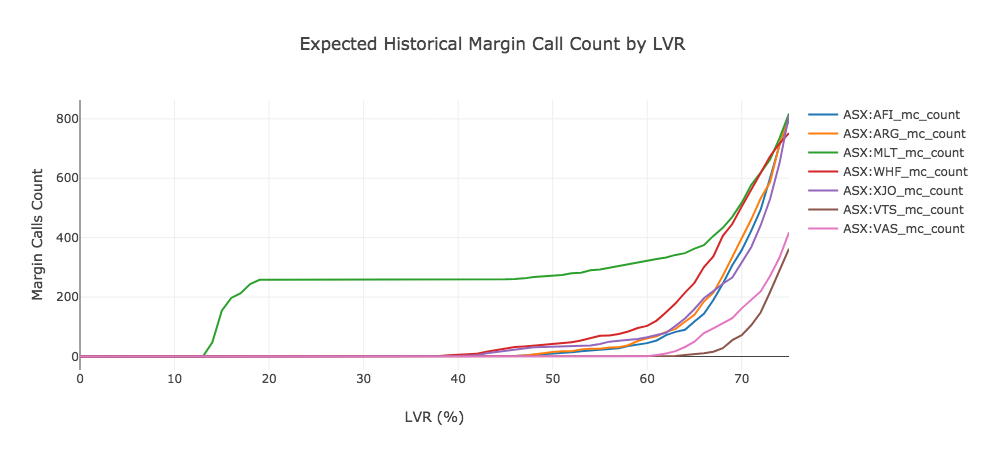

In [13]:
plot_cols = ['ASX:AFI_mc_count', 'ASX:ARG_mc_count',
       'ASX:MLT_mc_count', 'ASX:WHF_mc_count', 'ASX:XJO_mc_count',
       'ASX:VTS_mc_count', 'ASX:VAS_mc_count']


fig = pu.timeseries(df_mc_counts, 
                    x = 'lvr',
                    y = plot_cols,
                    xlabel = 'LVR (%)',
                    ylabel = 'Margin Calls Count',
                    title = 'Expected Historical Margin Call Count by LVR'
                   )

iplot(fig)

Clearly something is up with Milton Corp. It's WAYYYY off compared to the rest.

### Join All EOD Data into a Single DF

In [13]:
eod_list = [mc_results[x][0] for x in range(0,len(mc_results))]
eod_df = pd.concat(eod_list, axis=0)

eod_df.close.replace(0,np.nan, inplace=True)


eod_df.head()

date   open  high   low  close     volume   symbol  market_drawdown
0 2001-01-11  2.550  2.58  2.52   2.58  1510142.0  ASX:AFI         0.000000
1 2001-01-18  2.580  2.58  2.54   2.55  1549650.0  ASX:AFI        -1.162791
2 2001-01-25  2.550  2.97  2.55   2.97  1009314.0  ASX:AFI         0.000000
3 2001-02-01  2.582  2.60  2.55   2.57  1241811.0  ASX:AFI       -13.468013
4 2001-02-08  2.580  2.64  2.55   2.63  1553405.0  ASX:AFI       -11.447811

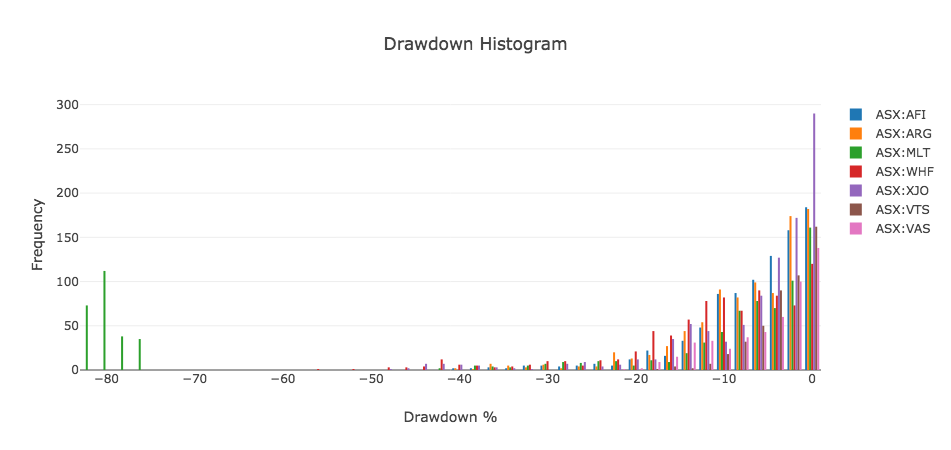

In [14]:
# Drawdown Distributions
plot_cols = ['ASX:AFI','ASX:ARG','ASX:MLT','ASX:WHF','ASX:XJO','ASX:VTS','ASX:VAS']

fig = pu.histogram(df = eod_df,
                   values='market_drawdown',
                   shape='long',
                   key_col = 'symbol',
#                    keys = 'ASX:MLT',
                   keys = plot_cols,
                   xlabel = "Drawdown %",
                   ylabel = "Frequency",
                   title = "Drawdown Histogram")
iplot(fig)

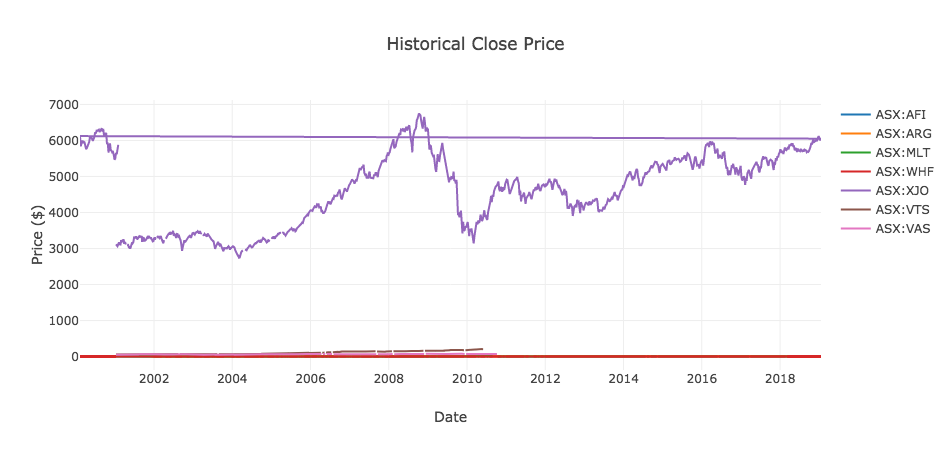

In [15]:
# Time Series
plot_cols = ['ASX:AFI','ASX:ARG','ASX:MLT','ASX:WHF','ASX:XJO','ASX:VTS','ASX:VAS']

fig = pu.timeseries(df = eod_df,
                    x = 'date',
                    y = 'close',
                    title = 'Historical Close Price',
                    xlabel = 'Date',
                    ylabel = 'Price ($)',
                    shape = 'long',
                    key_col = 'symbol',
                    keys = plot_cols)

iplot(fig)

# Things to fix
1. Why is a bunch of data missing from 2010-2019?
2. What's up with the weird straight lines in the plots?
3. Why do some of the timeseries appear discontinuous?

In [ ]:
eod_df[eod_df['symbol'] = 'ASX:WHF']

# Misc Junk

In [ ]:
margin_call_samples("VAS.AX", 52, )

In [423]:
# Get historical price data
df_eod = get_historical_data(alpha_vantage_key, time_slice='weekly', symbol=symbol)

# # Calculate LVR over time
# df_margin_loan = calc_lvr(df = df_eod,
#                           initial_investment = 50000,
#                           initial_lvr = starting_lvr)

# Calculate Drawdown
window_size = 52 # 1 year
df_margin_loan = calc_drawdown(df_eod, price_col = 'close', window_size = window_size)

In [374]:
df_margin_loan.head()

date   open   high    low  close  volume  market_drawdown
0 2009-05-22  60.30  60.30  57.82  57.82  1775.0         0.000000
1 2009-05-29  57.25  58.48  57.25  58.12   481.0         0.000000
2 2009-06-05  58.12  59.27  58.00  59.12  3601.0         0.000000
3 2009-06-12  59.12  59.65  58.57  58.57   453.0        -0.930311
4 2009-06-19  59.05  59.06  57.51  57.51  1214.0        -2.723275

In [436]:
# For every possible lvr, calculate drawdown required to trigger a margin call
# Assuming max_lvr of 65% & buffer of 10%
max_lvr = 0.65
buffer = 0.1
step_size = 0.05
lvr_range = np.arange(0, max_lvr+buffer+step_size, step_size)

df_mc_triggers = pd.DataFrame({
    "lvr": lvr_range,
    "mc_trigger": [calc_margin_call_drop(x, max_lvr, buffer) for x in lvr_range]
})

In [442]:
df_mc_triggers.lvr.max()

0.75

In [437]:
mc_counts = list()

for row, col in df_mc_triggers.iterrows():
    # Identify drawdowns that would have caused a margin call
    margin_calls = df_margin_loan['market_drawdown'].apply(
        lambda x: 1 if abs(x) > col['mc_trigger'] and x < 1 else 0)

    # Count instances
    counts = margin_calls.value_counts()
    mc_count = counts[1] if(len(counts)>1) else 0

    mc_counts.append(mc_count)
    
df_mc_triggers['margin_calls'] = mc_counts
df_mc_triggers

symbol   lvr  mc_trigger  margin_calls
0     VTS  0.00  100.000000             0
1     VTS  0.05   93.333333             0
2     VTS  0.10   86.666667             0
3     VTS  0.15   80.000000             0
4     VTS  0.20   73.333333             0
5     VTS  0.25   66.666667             0
6     VTS  0.30   60.000000             0
7     VTS  0.35   53.333333             0
8     VTS  0.40   46.666667             0
9     VTS  0.45   40.000000             0
10    VTS  0.50   33.333333             0
11    VTS  0.55   26.666667             0
12    VTS  0.60   20.000000             0
13    VTS  0.65   13.333333             7
14    VTS  0.70    6.666667            72
15    VTS  0.75    0.000000           363

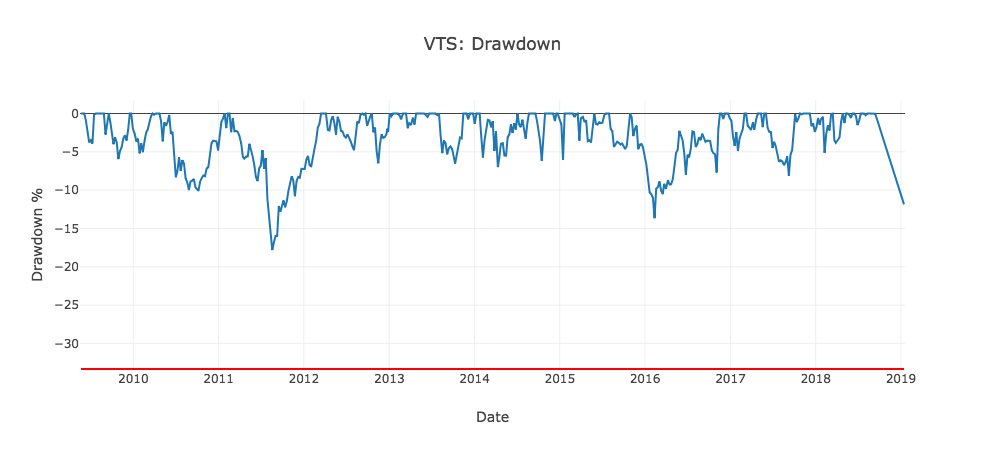

In [340]:
title = '{}: Drawdown'.format(symbol)
fig = pu.timeseries(df_margin_loan[(df_margin_loan.market_drawdown > -100)],
                    x='date',
                    y=['market_drawdown'],
                    title=title,
                    ylabel = 'Drawdown %', 
                    xlabel='Date')

margin_call_trigger = {
    'type': 'line',
    'x0': df_margin_loan['date'].min(),
    'x1': df_margin_loan['date'].max(),
    'y0': mc_drop_trigger,
    'y1': mc_drop_trigger,
    'line': {
        'color': 'red',
        'width': 2
    }
}


fig.layout['shapes'].append(margin_call_trigger)

iplot(fig)

In [375]:
# Calculate fall required to trigger a margin call
mc_drop_trigger = -1 * calc_margin_call_drop(starting_lvr, max_lvr, buffer)
mc_drop_trigger

-33.333333333333336

In [341]:
min_margin_call_events = df_margin_loan[df_margin_loan.market_drawdown > -100].margin_called.diff().apply(lambda x: 1 if x==1 else 0).sum()
print("{}: LVR of {}% resulted in at least {} drops over {}% triggering a margin call".format(symbol,
                                                                                              round(starting_lvr*100,2),
                                                                                              min_margin_call_events,
                                                                                              round(mc_drop_trigger*-1, 2)))

max_lvr_to_avoid_margin_call = calc_max_safe_lvr(df_margin_loan[df_margin_loan.market_drawdown > -100].market_drawdown.min(), max_lvr, buffer)
print("{}: Max LVR of {}% historically required to avoid a margin call".format(symbol, round(max_lvr_to_avoid_margin_call,1)))

VTS: LVR of 50.0% resulted in at least 0 drops over 33.33% triggering a margin call
VTS: Max LVR of 61.6% historically required to avoid a margin call
